In [79]:
# This notebook plots predicted concentration gradients for different wounding conditions 
import sys
import os

sys.path.append(os.path.abspath('..'))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import expi
from scipy.stats import mode
import random
#from Utilities.plotting import plot_find_wound_location,plotxy_space_bins,plotxy_time_bins,observed_bias_plotting

In [80]:
# Load inferred parameters for each data type 
Post_attractant_control = np.load("../data/New_data/Attractant_control.npy", allow_pickle=True)
Post_attractant_mcr = np.load("../data/New_data/Attractant_post_mcr.npy", allow_pickle=True)

posterior_samples_mcr = Post_attractant_mcr[0].get_chain(discard=5000, thin=10, flat = True)
posterior_samples_control = Post_attractant_control[0].get_chain(discard=5000, thin=10, flat = True)

In [81]:
# Multiple wound function, using the Exponential Integral
def concentration_multiple_sources(x, y, ts, source_locations, q,D, tau):
    concentration_sum = np.zeros_like(x)
    
    for qx, qy in source_locations:
        r = np.sqrt((x - qx)**2 + (y - qy)**2)
        factor = q / (4 * np.pi * D)
        
        if ts < tau:
            concentration_sum += -factor * expi(-r**2 / (4 * D * ts))
        else:
            concentration_sum += factor * (expi(-r**2 / (4 * D * (ts - tau))) - expi(-r**2 / (4 * D * ts)))
    
    return concentration_sum


In [92]:
# Circle function for source points
def circle(r, thetas):
    xs = r * np.cos(thetas)
    ys = r * np.sin(thetas)
    return xs, ys  # Returning xs and ys as a tuple

# Example usage:
import matplotlib.pyplot as plt

# Create an array of angles from 0 to π (180 degrees)
theta = np.linspace(0, np.pi, 10)

# Define the radius of the circle
radius = 30.0

# Calculate the x and y coordinates for points on the half-circle
xs, ys = circle(radius, theta)

def location_of_sources(halfwound_on):
    if halfwound_on == True:
        source_locations = [(xs[i],ys[i]) for i in range(len(xs))]
    else:
        source_locations = [(0, 50), (0, -50)]
    return source_locations
    
def strength_of_sources(halfwound_on, flow_rate):
    if halfwound_on == True:
        source_strength = flow_rate / len(xs)
    else:
        source_strength = flow_rate # don't adjust wound strength for two wounds!
    return source_strength

In [83]:
# extract mean parameters from Posterior distributions, i.e. Diffusion coefficient, flow rate, tau 
D_mean_control = np.mean(posterior_samples_control[:,1])
q_mean_control = np.mean(posterior_samples_control[:,0]) 
tau_mean_control = np.mean(posterior_samples_control[:,2]) 

D_mean_mcr = np.mean(posterior_samples_mcr[:,1])
q_mean_mcr = np.mean(posterior_samples_mcr[:,0]) 
tau_mean_mcr = np.mean(posterior_samples_mcr[:,2]) 

In [84]:
D_mean_control, q_mean_control, tau_mean_control

(394.89495145898155, 556.7590622326513, 19.13326776868955)

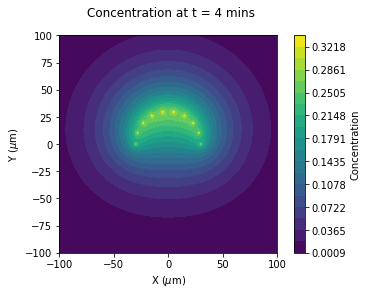

In [85]:
# Produce heatmap of chemoattractant concentration 

# Half wound on or off, if off two wounds are plotted instead

halfwound_on = True
L = 100 # sets the range of plot from -L to L
# Define the grid 
x = np.linspace(-L, L, 1000)
y = np.linspace(-L, L, 1000)
distance = np.linspace(-L,L,1000) # Distance in microns for plotting
X, Y = np.meshgrid(x, y)

# Define the positions of the point sources
source_locations = location_of_sources(halfwound_on)
source_strength = strength_of_sources(halfwound_on, q_mean_control)
# Set the values of ts, D, and tau
ts = 4 # current time - min
# tau = 18 # production time up to - mins 

# Calculate the concentration at each point in the grid
concentration = concentration_multiple_sources(X, Y, ts, source_locations, source_strength, D_mean_control, tau_mean_control)
levels = np.linspace(concentration.min(),concentration.max(), 20)

# plotting 
fig, ax = plt.subplots(1)
ax.set_aspect('equal')

im = ax.contourf(X, Y, concentration, levels=levels)

ax.set_xlabel('X ($\mu$m)')
ax.set_ylabel('Y ($\mu$m)')
cbar = fig.colorbar(im)
cbar.set_label('Concentration')

fig.suptitle(f'Concentration at t = {int(ts)} mins')
if halfwound_on == True:
    plt.savefig(f"Figures/Half wound concentration at t = {ts}.pdf")
else:
    plt.savefig(f"Figures/Two wound concentration at t = {ts}.pdf")
plt.show()


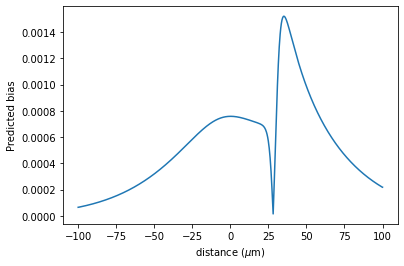

In [102]:
# next will plot line plots of the predicted bias for half wound data
# this needs to be averaged over multiple time-windows to compare with data
# Define the positions of the point sources
source_locations = location_of_sources(halfwound_on)
concentration_half = concentration_multiple_sources(X, Y, 5, source_locations, source_strength,D_mean_control, tau_mean_control)
absolute_concentration_grad = np.absolute(np.gradient(concentration_half[:,500]))
plt.plot(distance,absolute_concentration_grad)
plt.xlabel("distance ($\mu$m)")
plt.ylabel("Predicted bias")
plt.show()

In [87]:
# plot muliple lines for different samples from the posterior distribution
multi_gradients = []
for i in range(10):
    concentration_half = concentration_multiple_sources(X, Y, 5, source_locations, source_strength,random.choice(posterior_samples_control[:,1]), tau_mean_control)
    multi_gradients.append(np.absolute(np.gradient(concentration_half[:,500])))

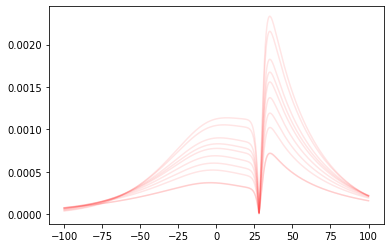

In [88]:
for i in range(len(multi_gradients)):
    plt.plot(distance,multi_gradients[i], 'r', alpha = 0.1)
plt.show()

In [93]:
# Save data for two wound plots into spreadsheet
source_locations2 = location_of_sources(False)
source_strength2 = strength_of_sources(False,q_mean_control)

concentration_1 = concentration_multiple_sources(X, Y, 1, source_locations2, source_strength2, D_mean_control, tau_mean_control)
concentration_18 = concentration_multiple_sources(X, Y, 18.0001, source_locations2, source_strength2, D_mean_control, tau_mean_control)
concentration_20 = concentration_multiple_sources(X, Y, 20, source_locations2, source_strength2, D_mean_control, tau_mean_control)

tws = {"1 Minute":np.gradient(concentration_1[375:625,500]), "18 Minutes": np.gradient(concentration_18[375:625,500]), "20 Minutes": np.gradient(concentration_20[375:625,500]) }

Two_wound = pd.DataFrame(data=tws)

Two_wound.to_excel("Two_wound_gradients.xlsx")

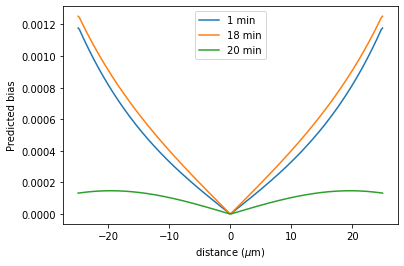

In [101]:
xmin = 375
xmax = 625
plt.plot(distance[xmin:xmax],np.absolute(np.gradient(concentration_1[xmin:xmax,500])), label = "1 min")
plt.plot(distance[xmin:xmax],np.absolute(np.gradient(concentration_18[xmin:xmax,500])), label = "18 min")
plt.plot(distance[xmin:xmax],np.absolute(np.gradient(concentration_20[xmin:xmax,500])), label = "20 min")

#plt.plot(np.gradient(concentration[350:650,500]))
# plt.ylim(0,0.2)
plt.legend()
plt.xlabel("distance ($\mu$m)")
plt.ylabel("Predicted bias")
plt.savefig("Figures/Two wound predictions.pdf")
plt.show()

In [91]:
concentration_half_1 = concentration_multiple_sources(X, Y, 1, source_locations, source_strength, D_mean_control, tau_mean_control)
concentration_half_18 = concentration_multiple_sources(X, Y, 18, source_locations, source_strength, D_mean_control, tau_mean_control)
concentration_half_20 = concentration_multiple_sources(X, Y, 20, source_locations, source_strength, D_mean_control, tau_mean_control)

c = {'Time = 1': np.absolute(concentration_half_1[:,500]), 'Time = 18': np.absolute(concentration_half_18[:,500]), 'Time = 20':np.absolute(concentration_half_20[:,500])}
Concentrations = pd.DataFrame(data=c)